## Using CNN for radiomics study

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pydicom
from pydicom.data import get_testdata_file, get_testdata_files
from pydicom.filereader import read_dicomdir
import pydicom_seg
import SimpleITK

import os
import sys
import glob

#import tensorflow as tf
#import keras

Plan of attack:

1. Load DICOM images with segmentation as mask
2. Remove everything outside the mask
3. Set up neural network and pass it through

### Loading DICOM images

In [2]:
os.chdir('/Volumes/Time Machine Backups/Radiomics-NSCLC-v3/NSCLC-Radiomics/')
os.chdir('LUNG1-001/09-18-2008-StudyID-69331/0-82046')

In [3]:
# load the DICOM files
files = []

for fname in os.listdir():
    print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files)))

loading: 000000.dcm
loading: 000001.dcm
loading: 000002.dcm
loading: 000003.dcm
loading: 000004.dcm
loading: 000005.dcm
loading: 000006.dcm
loading: 000007.dcm
loading: 000008.dcm
loading: 000009.dcm
loading: 000010.dcm
loading: 000011.dcm
loading: 000012.dcm
loading: 000013.dcm
loading: 000014.dcm
loading: 000015.dcm
loading: 000016.dcm
loading: 000017.dcm
loading: 000018.dcm
loading: 000019.dcm
loading: 000020.dcm
loading: 000021.dcm
loading: 000022.dcm
loading: 000023.dcm
loading: 000024.dcm
loading: 000025.dcm
loading: 000026.dcm
loading: 000027.dcm
loading: 000028.dcm
loading: 000029.dcm
loading: 000030.dcm
loading: 000031.dcm
loading: 000032.dcm
loading: 000033.dcm
loading: 000034.dcm
loading: 000035.dcm
loading: 000036.dcm
loading: 000037.dcm
loading: 000038.dcm
loading: 000039.dcm
loading: 000040.dcm
loading: 000041.dcm
loading: 000042.dcm
loading: 000043.dcm
loading: 000044.dcm
loading: 000045.dcm
loading: 000046.dcm
loading: 000047.dcm
loading: 000048.dcm
loading: 000049.dcm


In [4]:
# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

skipped, no SliceLocation: 0


In [5]:
# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

In [6]:
# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

In [7]:
print(f'Pixel Spacing: {ps}; Slice Thickness: {ss}')

Pixel Spacing: [0.9765625, 0.9765625]; Slice Thickness: 3


In [8]:
print(f'Aspects for axial, sagittal and coronal: {ax_aspect}, {sag_aspect}, {cor_aspect}')

Aspects for axial, sagittal and coronal: 1.0, 0.3255208333333333, 3.072


In [9]:
# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

In [10]:
# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

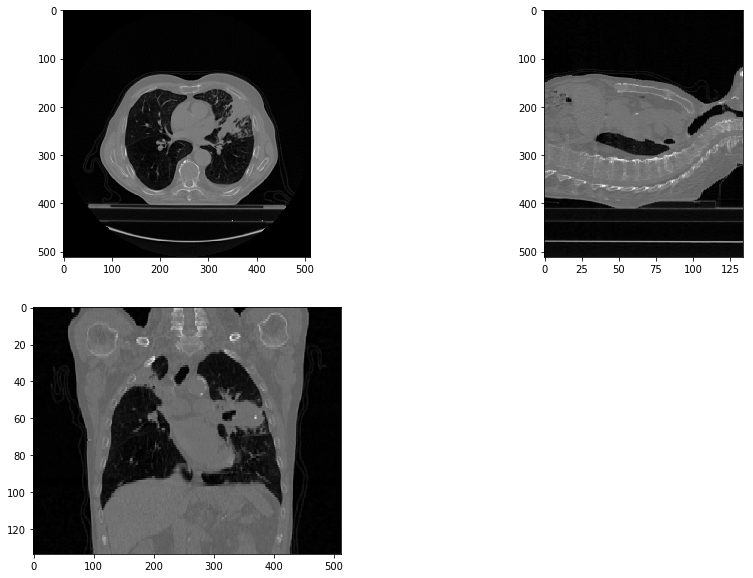

In [11]:
# plot 3 orthogonal slices
plt.figure(figsize=(15,10))
plt.gray()

a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, ::-1].T) #-1 to flip the SI directions
a3.set_aspect(cor_aspect)

plt.show()

The DICOM images seem to have been loaded correctly. We should now look at the mask.

In [12]:
os.getcwd()

'/Volumes/Time Machine Backups/Radiomics-NSCLC-v3/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-69331/0-82046'

In [13]:
dcm = pydicom.dcmread('../../02-25-2019-CTLUNG-69331/300-Segmentation-64821/000000.dcm')

reader = pydicom_seg.MultiClassReader()
result = reader.read(dcm)

image_data = result.data  # directly available
image = result.image  # lazy construction

DICOM-SEG does not specify "(0062, 0013) SegmentsOverlap", assuming UNDEFINED and checking pixels


Look at the shape of the array:

In [21]:
image_data.shape

(134, 512, 512)

How does this compare to the shape of the array of the CT image series:

In [26]:
img_shape

[512, 512, 134]

Visualize the mask at the middle:

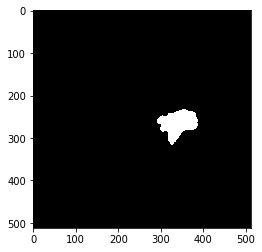

In [35]:
plt.imshow(image_data[image_data.shape[0]//2+7, :, :])

This seems to show the axial slice. The L-R and A-P directions seem to be consistent with the CT image from before.

Now show different slices of the mask:

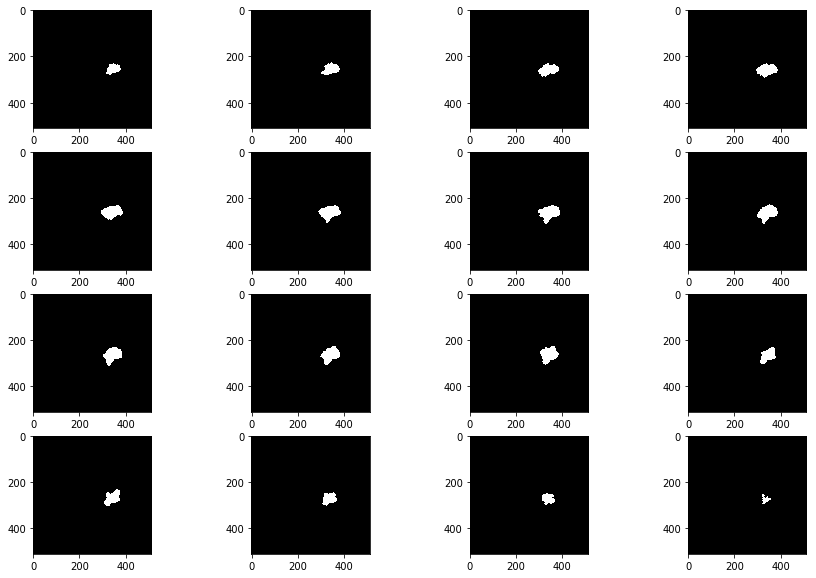

In [38]:
plt.figure(figsize=(15,10))

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(image_data[image_data.shape[0]//2+i, :, :])

plt.show()

I then compared with the images on 3D Slicer GUI. As the index increases, the slice seems to move towards the superior direction (i.e. towards the head).